In [2]:
import pandas as pd
from fastai import *
from fastai.text import * 

In [3]:
DATA_PATH = './data'

# DATA PREPARATION

In [1]:
def prepare_csv(source, target):
    df = pd.read_csv(source, sep= '%%%%', header=None)
    df[['label', 'question']] = df.iloc[:,0].str.split(":", n = 1, expand = True) 
    df[['label_detail', 'question']] = df.question.str.split(" ", n = 1, expand = True) 
    df = df.drop(df.columns[0], axis=1)
    df.to_csv(target, index=False)

In [4]:
prepare_csv(DATA_PATH  + '/TREC_10.label', DATA_PATH  + '/TREC_10.csv')
prepare_csv(DATA_PATH  + '/train_5500.label', DATA_PATH  + '/train_5500.csv' )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
df_valid = pd.read_csv(DATA_PATH  + '/TREC_10.csv')
df_train = pd.read_csv(DATA_PATH  + '/train_5500.csv')
df_valid['is_valid'] = 1
df_train['is_valid'] = 0
df_all = pd.concat([df_valid, df_train], ignore_index=True)

In [5]:
df_all

,label,question,label_detail,is_valid
0,NUM,How far is it from Denver to Aspen ?,dist,1
1,LOC,"What county is Modesto , California in ?",city,1
2,HUM,Who was Galileo ?,desc,1
3,DESC,What is an atom ?,def,1
4,NUM,When did Hawaii become a state ?,date,1
5,NUM,How tall is the Sears Building ?,dist,1
6,HUM,George Bush purchased a small interest in whic...,gr,1
7,ENTY,What is Australia 's national flower ?,plant,1
8,DESC,Why does the moon turn orange ?,reason,1
9,DESC,What is autism ?,def,1


# LANGUAGE MODEL

In [6]:
# Creating databunch with all data for language model
databunch_lm = (
        TextList.from_df(df=df_all, path=DATA_PATH, cols=['question'])
            .split_by_rand_pct()
            .label_for_lm()
            .databunch())

databunch_lm.save('databunch_lm.pkl')
databunch_lm = load_data(DATA_PATH, fname='databunch_lm.pkl')

In [7]:
# Creating learner with pretrained model
language_model_learner = language_model_learner(databunch_lm, AWD_LSTM, drop_mult=0.5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-02


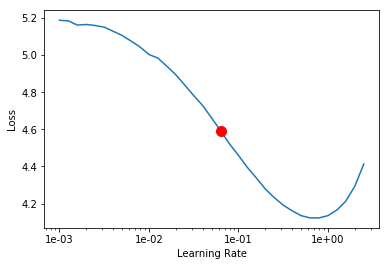

In [8]:
# Finding the best learning rate 

# language_model_learner.lr_find(1e-4, 10,50)
# language_model_learner.recorder.plot(suggestion=True)

In [9]:
# Training only last layer
language_model_learner.fit_one_cycle(1, 3e-1)

epoch,train_loss,valid_loss,accuracy,time
0,4.072760,3.169302,0.444420,01:42


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03


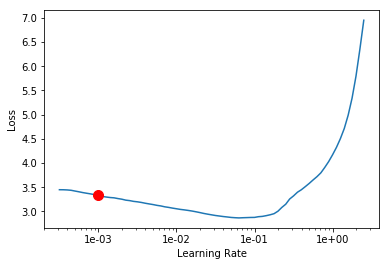

In [10]:
# Finding the best learning rate when unfreezed

# language_model_learner.unfreeze()
# language_model_learner.lr_find(1e-4, 10)
# language_model_learner.recorder.plot(suggestion=True)

In [11]:
# Unfreezing and training all layers
language_model_learner.unfreeze()
language_model_learner.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.144612,2.737103,0.471261,03:45
1,2.857237,2.557020,0.502623,03:47
2,2.640059,2.520906,0.512835,03:43


In [12]:
# Saving encoder
language_model_learner.save_encoder('encoder')

# CLASSIFIER

In [22]:
# Creating databunch with all data for classifier using previous vocab
databunch_classifier = (
        TextList.from_df(df=df_all, path=DATA_PATH, cols=['question'], vocab=databunch_lm.train_ds.vocab)
            .split_from_df(col='is_valid')
            .label_from_df(cols='label')
            .databunch())

databunch_classifier.save('databunch_classifier.pkl')
databunch_classifier = load_data(DATA_PATH, fname='databunch_classifier.pkl', bs=16)

In [23]:
# Creating text classifier learner
classifier_learner = text_classifier_learner(databunch_classifier, AWD_LSTM, drop_mult=0.3)
classifier_learner.load_encoder('encoder')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [24]:
# Example of a batch
databunch_classifier.show_batch()

text,target
"xxbos xxmaj who was named xxmaj xxunk of the xxmaj ocean xxmaj xxunk and xxmaj xxunk and xxmaj governor xxmaj general of all the islands he xxunk discover , and also xxunk xxunk ? ? of all xxunk of his xxunk",HUM
"xxbos xxmaj who is the director of the international group called the xxmaj human xxmaj xxunk xxmaj organization , xxup hugo , that is xxunk to xxunk gene - xxunk research worldwide",HUM
xxbos xxmaj what is the name of the xxunk xxunk xxunk disease which xxunk the xxunk xxunk that xxunk xxunk xxunk xxunk a xxunk xxunk of xxunk in the body,ENTY
"xxbos xxmaj where is it xxunk to xxunk the xxunk ship , xxmaj xxunk xxmaj xxunk , which xxmaj xxunk xxmaj xxunk xxunk are xxunk into a xxunk museum",LOC
xxbos xxmaj how much xxunk is the new xxunk carbon material invented by the xxmaj tokyo xxmaj institute of xxmaj xxunk compared with the material made from xxunk,NUM


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03


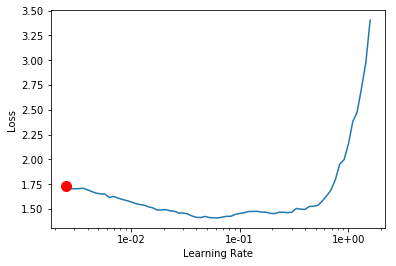

In [16]:
# Finding learning rate

# classifier_learner.lr_find(1e-3, 10)
# classifier_learner.recorder.plot(suggestion=True)

In [25]:
# Training only last layer
classifier_learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.881712,0.542160,0.796000,03:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-05


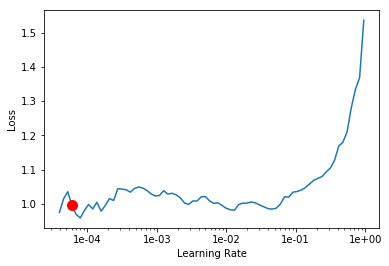

In [18]:
# Finding the best learning rate when freezed to -2

# classifier_learner.freeze_to(-2)
# classifier_learner.lr_find(1e-6, 10)
# classifier_learner.recorder.plot(suggestion=True)

In [26]:
# Training only last 2 layers

classifier_learner.freeze_to(-2)
classifier_learner.fit_one_cycle(1, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.819890,0.512707,0.804000,04:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


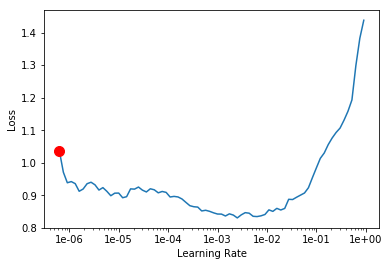

In [20]:
# Finding the best learning rate when unfreezed

# classifier_learner.unfreeze()
# classifier_learner.lr_find(1e-7, 10)
# classifier_learner.recorder.plot(suggestion=True)

In [27]:
classifier_learner.unfreeze()
classifier_learner.fit_one_cycle(6, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.726060,0.492940,0.830000,13:15
1,0.730668,0.491750,0.810000,13:55
2,0.688882,0.469450,0.826000,14:09
3,0.697103,0.457963,0.824000,14:20
4,0.714403,0.439669,0.836000,13:32
5,0.712503,0.452026,0.824000,13:49


In [28]:
classifier_learner.export()

In [29]:
classifier_learner = load_learner(DATA_PATH)

In [30]:
classifier_learner.predict("How many players are in a football field?")


(Category NUM,
 tensor(5),
 tensor([2.4393e-04, 2.2416e-02, 2.3997e-03, 4.4937e-04, 6.2155e-04, 9.7387e-01]))